In [1]:
# dependencies
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# file paths
full_dataPath = Path("./resources/full_data.csv")

In [3]:
# data import
df = pd.read_csv(full_dataPath).set_index('patient_id')
df['planet_id'] = df['planet_id'].replace({1:'Boran',2:'Radan'})
df.head()

,age,blood_pressure,exercise,weight,glucose,BMI,planet_id
patient_id,,,,,,,
5231,75.254768,194.639537,45.811801,145.294390,122.231550,1.005604,Boran
5502,78.425828,102.743158,43.031599,81.072209,77.593129,0.984347,Radan
8248,74.242965,189.628666,90.167716,139.689556,118.206986,0.972132,Boran
8495,79.982882,101.532439,84.264034,77.931413,75.550277,0.963410,Radan
8499,85.809577,104.635367,75.525589,82.481703,79.318150,1.021250,Radan


### Histogram of age distribution on each planet.
More information on how this plot was made can be found here: https://seaborn.pydata.org/tutorial/distributions.html

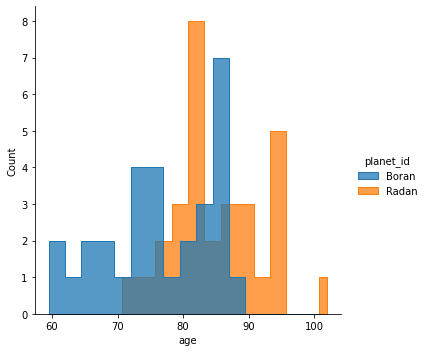

In [4]:
sns.displot(df, x='age', binwidth=2.5, hue='planet_id', element="step", multiple="dodge")

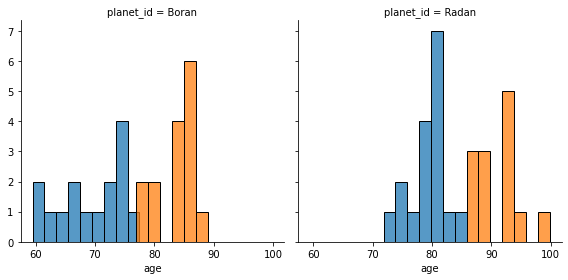

In [10]:
# Average value by planet for age
df_mean = df.groupby('planet_id').agg(np.mean)

# Function to check if patient's age is over or under life expectancy
def life_expectancy_check(age, planet_id):
    life_expectancy = df_mean['age'][planet_id]
    if age >= life_expectancy:
        return 1
    else:
        return 0

# Create new binary column to store whether or not patient exceeded average age
df['over_life_expectancy'] = df.apply(lambda x: life_expectancy_check(x['age'], x['planet_id']), axis=1)

g = sns.FacetGrid(df, col="planet_id", hue="over_life_expectancy", height=4)
g.map(sns.histplot, 'age', binwidth=2)

In [12]:
df[['over_life_expectancy','planet_id']].head()

,over_life_expectancy,planet_id
patient_id,,
5231,0,Boran
5502,0,Radan
8248,0,Boran
8495,0,Radan
8499,1,Radan


In [6]:
df_life_expectancy = df[['planet_id', 'over_life_expectancy']].pivot_table(index='planet_id',
                                                                           columns='over_life_expectancy',
                                                                           aggfunc='size')
df_life_expectancy

over_life_expectancy,0,1
planet_id,,
Boran,15,15
Radan,17,13


The mean life expectancy, assuming that the 'age' column corresponds to the age of each patient's death, is 76.42 years on Boran and 84.22 years on Radan.

### Blood pressure boxplot
There must be some strong gravity or terrible diets on Boran. The distribution of blood pressures is much larger on Boran, but that makes sense given how much higher the mean blood pressure is. Neither planet had any notable outliers.

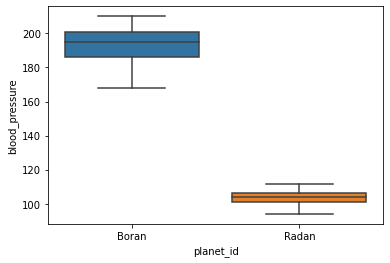

In [7]:
sns.boxplot(x='planet_id', y='blood_pressure', data=df)

Because the mean blood pressure on Boran is almost double the mean blood pressure on Radan, this graph is basically meaningless. It's impossible to tell how these distributions compare. I want to transform the graph so that the box plots show the relative distribution of each planet, with their means. I will create a `blood_pressure_dev` attribute that measures how many standard deviations from the blood pressure mean each point is. I'll then plot the new column with both box plots, and smoothed kde.

In [9]:
# Data frame to hold standard deviations
df_std_dev = df.groupby('planet_id').agg(np.std)

# Function to check if patient's age is over or under life expectancy
def bp_dev(bp, planet_id):
    std_dev = df_std_dev['blood_pressure'][planet_id]
    bp_mean = df_mean['blood_pressure'][planet_id]
    return ((bp-bp_mean)/std_dev)

# Create new column
df['blood_pressure_dev'] = df.apply(lambda x: bp_dev(x['blood_pressure'], x['planet_id']), axis=1)
df[['blood_pressure_dev','planet_id']].head()

,blood_pressure_dev,planet_id
patient_id,,
5231,0.093717,Boran
5502,-0.173020,Radan
8248,-0.372636,Boran
8495,-0.456428,Radan
8499,0.269913,Radan


In [ ]:
g = sns.boxplot(y='planet_id', x='blood_pressure_dev', orient='h', data=df)

In [ ]:
sns.kdeplot(data=df, x="blood_pressure_dev", hue="planet_id")

### Blood Pressure scatterplots
Blood pressure has really strong correlations between weight, glucose and BMI. There's clear colinearity. There's a weaker correlation with age, but it's still visible. The data is much noisier for exercise.

In [ ]:
g = sns.PairGrid(data=df, y_vars=["blood_pressure"], x_vars=["age","exercise"], hue="planet_id", height=4)
g.map(sns.scatterplot)

In [ ]:
g = sns.PairGrid(data=df, y_vars=["blood_pressure"], x_vars=["weight","glucose","BMI"], hue="planet_id", height=4)
g.map(sns.scatterplot)

One thing I like to do when I'm exploring data with relatively small dimensionality is look at how all the variables affect all the other variables. It's a just a quick way to get oriented and see if anything catches my attention.

In [ ]:
df = df.drop(columns=['blood_pressure_dev','over_life_expectancy'])
sns.pairplot(df, hue="planet_id")